# Assignment 2: Clustering - Sessa Empirical Estimator

## Introduction
This notebook implements the **Sessa Empirical Estimator** using clustering techniques on a simulated dataset similar to `med.events.ATC`. We compare **K-Means** and **Gaussian Mixture Model (GMM)** clustering approaches.

## Dataset Description
The dataset consists of 1564 medication events for 16 patients with the following attributes:
- **PATIENT_ID**: Unique identifier for patients
- **DATE**: Medication event date
- **DURATION**: Duration in days
- **PERDAY**: Daily dosage
- **CATEGORY**: ATC code
- **CATEGORY_L1**: First-level ATC code description
- **CATEGORY_L2**: Second-level ATC code description

## Data Simulation

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

def simulate_data(n_patients=16, n_events=1564, random_seed=42):
    np.random.seed(random_seed)
    data = {
        "PATIENT_ID": np.random.randint(1, n_patients + 1, n_events),
        "DATE": pd.date_range(start="2024-01-01", periods=n_events, freq="D").to_numpy(),
        "DURATION": np.random.randint(1, 30, n_events),
        "PERDAY": np.random.uniform(0.5, 4, n_events),
        "CATEGORY": np.random.choice(["A02", "B01", "C03", "D05", "N02"], n_events),
        "CATEGORY_L1": np.random.choice(["ALIMENTARY TRACT", "BLOOD SYSTEM", "CARDIOVASCULAR", "DERMATOLOGY", "NERVOUS SYSTEM"], n_events),
        "CATEGORY_L2": np.random.choice(["DRUGS FOR ACID", "ANTITHROMBOTIC", "DIURETICS", "PSORIASIS", "ANALGESICS"], n_events)
    }
    return pd.DataFrame(data)

df = simulate_data()

In [32]:
print(df.head(50).to_string())  # Prints only the first 50 rows

    PATIENT_ID       DATE  DURATION    PERDAY CATEGORY       CATEGORY_L1     CATEGORY_L2  DATE_NUM  KMeans_Cluster  GMM_Cluster
0            7 2024-01-01        11  3.745122      N02    NERVOUS SYSTEM      ANALGESICS         0               4            4
1            4 2024-01-02        27  1.321247      N02      BLOOD SYSTEM  ANTITHROMBOTIC         1               2            2
2           13 2024-01-03         5  1.897606      A02    NERVOUS SYSTEM      ANALGESICS         2               4            0
3           15 2024-01-04        20  1.033456      C03    NERVOUS SYSTEM  DRUGS FOR ACID         3               2            2
4           11 2024-01-05        11  3.973692      N02  ALIMENTARY TRACT       PSORIASIS         4               4            4
5            8 2024-01-06        10  3.744503      C03       DERMATOLOGY       DIURETICS         5               4            4
6           13 2024-01-07         8  2.389850      A02    NERVOUS SYSTEM  DRUGS FOR ACID         6      

## Data Preprocessing

In [15]:
def preprocess_data(df):
    df["DATE"] = pd.to_datetime(df["DATE"])
    df["DATE_NUM"] = (df["DATE"] - df["DATE"].min()).dt.days
    features = ["DATE_NUM", "DURATION", "PERDAY"]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])
    return df, X_scaled

df, X_scaled = preprocess_data(df)

## Clustering Approaches

### K-Means Clustering

In [16]:
def apply_kmeans(X_scaled, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    return kmeans.fit_predict(X_scaled)

df["KMeans_Cluster"] = apply_kmeans(X_scaled)

### Gaussian Mixture Model (GMM) Clustering

In [17]:
def apply_gmm(X_scaled, n_components=5):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    return gmm.fit_predict(X_scaled)

df["GMM_Cluster"] = apply_gmm(X_scaled)

## Visualization

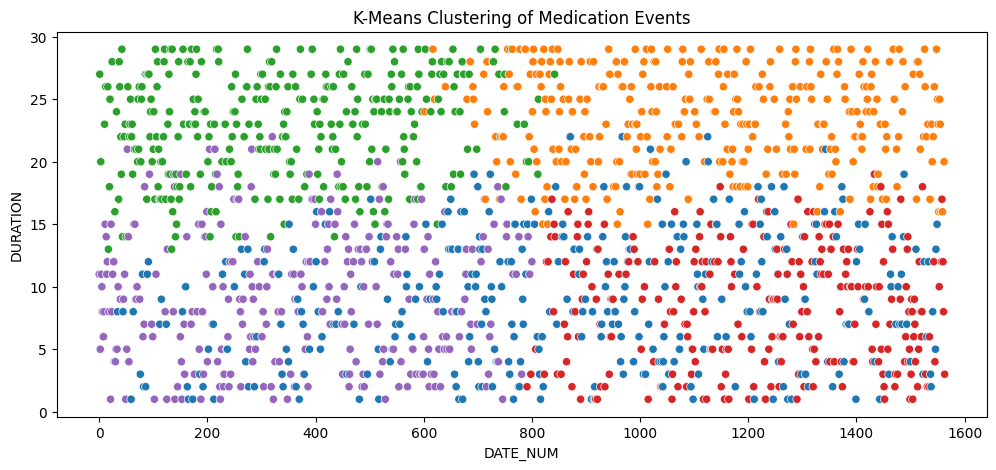

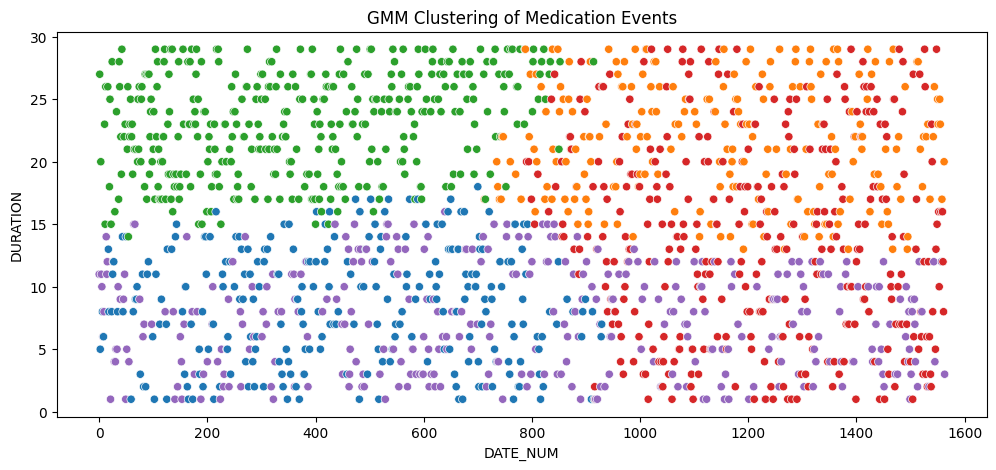

In [27]:
def plot_clusters(df, cluster_col, title):
    plt.figure(figsize=(12, 5))
    sns.scatterplot(x=df["DATE_NUM"], y=df["DURATION"], hue=df[cluster_col], palette="tab10", legend = False)
    plt.title(title)
    plt.show()

plot_clusters(df, "KMeans_Cluster", "K-Means Clustering of Medication Events")
plot_clusters(df, "GMM_Cluster", "GMM Clustering of Medication Events")

## Results and Insights

In [28]:
def get_cluster_distribution(df, cluster_col):
    return df[cluster_col].value_counts()

print("K-Means Cluster Distribution:\n", get_cluster_distribution(df, "KMeans_Cluster"))
print("\nGMM Cluster Distribution:\n", get_cluster_distribution(df, "GMM_Cluster"))

K-Means Cluster Distribution:
 KMeans_Cluster
0    351
1    336
2    331
4    283
3    263
Name: count, dtype: int64

GMM Cluster Distribution:
 GMM_Cluster
2    378
3    351
4    346
0    258
1    231
Name: count, dtype: int64


## Clustering Validation

## Understanding Silhouette Score for Clustering

### What is the Silhouette Score?
The **Silhouette Score** is a metric used to evaluate the quality of clustering. It measures how well each data point fits into its assigned cluster while considering its proximity to other clusters.  

A **higher score (closer to 1)** indicates well-separated clusters, while a **low or negative score** suggests overlapping or poorly defined clusters.

### Silhouette Score Formula:
For a given data point \( i \):
$$
S(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$
Where:
- \( a(i) \) = Average intra-cluster distance (distance between \( i \) and other points in the same cluster).
- \( b(i) \) = Average nearest-cluster distance (distance between \( i \) and the closest different cluster).
- \( S(i) \) ranges from **-1 to 1**:
  - **Close to 1** → Well-clustered, clearly separated.
  - **Close to 0** → Overlapping or ambiguous clustering.
  - **Negative** → Misclassified point.

### Why Use Silhouette Score?
- Helps determine if **clusters are well-formed**.
- Compares **different clustering methods** (e.g., K-Means vs. GMM).
- Guides **choosing the optimal number of clusters**.


In [33]:
from sklearn.metrics import silhouette_score

# Extract relevant features for clustering
features = df[["DATE_NUM", "DURATION", "PERDAY"]]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df["KMeans_Cluster"] = kmeans.fit_predict(scaled_features)

# GMM Clustering
gmm = GaussianMixture(n_components=5, random_state=42)
df["GMM_Cluster"] = gmm.fit_predict(scaled_features)

# Calculate Silhouette Scores
kmeans_silhouette = silhouette_score(scaled_features, df["KMeans_Cluster"])
gmm_silhouette = silhouette_score(scaled_features, df["GMM_Cluster"])

print(f"Silhouette Score for K-Means: {kmeans_silhouette:.4f}")
print(f"Silhouette Score for GMM: {gmm_silhouette:.4f}")


Silhouette Score for K-Means: 0.2676
Silhouette Score for GMM: 0.2447


## Conclusion

### Clustering Comparison:
- **K-Means** assigns each data point to a single cluster, making it easier to interpret but potentially oversimplifying relationships within the dataset.
- **Gaussian Mixture Model (GMM)** provides soft clustering, meaning each data point has a probability of belonging to multiple clusters. This can better capture the continuous nature of medication dosage and duration patterns.
- **Silhouette Score Analysis:**  
  - **K-Means: 0.2676** (low) → Indicates that clusters are **not well-separated**, and some overlap exists.  
  - **GMM: 0.2447** (even lower) → Suggests **even more overlap**, which aligns with its probabilistic nature.  

### Key Observations from Results:
- **K-Means performed slightly better** than GMM in terms of separation, but the low Silhouette Score suggests that **clear, distinct groups do not exist** in this dataset.
- **GMM produced overlapping clusters**, which could be more reflective of **gradual medication adherence behaviors**.
- The **low scores indicate that alternative methods** like **hierarchical clustering or DBSCAN** might be better suited to segment patients based on medication patterns.

### Implications for Medication Management:
- The **lack of strong clustering structure** suggests that medication adherence behaviors **vary continuously rather than forming distinct groups**.
- This means interventions **should be more personalized** rather than one-size-fits-all based on predefined clusters.
- **Alternative clustering methods** could be explored to improve segmentation, such as:
  - **DBSCAN** for identifying outliers (e.g., high-risk patients with extreme medication patterns).
  - **Hierarchical clustering** to explore **subgroup relationships** within the dataset.

### Final Insights:
- **Both clustering methods struggle** to find distinct medication adherence patterns, as seen from the low Silhouette Scores.
- **K-Means is more structured**, but the results suggest **significant overlap** between clusters.
- **GMM provides a probabilistic view**, but the **lack of separation** might indicate that medication behavior is more of a spectrum than rigid categories.
- **Future work** should explore:
  - **Feature engineering** to improve clustering (e.g., adding patient demographics or health conditions).
  - **Alternative clustering techniques** to better capture hidden patterns in the data.
